# Linear Regression Real World Data

In [1]:

import os
os.environ["PYTHONWARNINGS"] = "ignore"

import numpy as np
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from actual import actual_effect
from LAGS import LAGS, adaptive_LAGS
from first_order import first_order, adaptive_first_order

from target import target_value

from ucimlrepo import fetch_ucirepo

In [2]:
ks = list(range(1, 51, 2)) + [50]
methods = ["LAGS", "Adaptive LAGS", "First-order", "Adaptive First-order"]
dataset = "UCI"
UCI_id = 186
test_size = 50
num_methods, num_experiments, num_ks = len(methods), test_size, len(ks)

In [3]:
# fetch dataset
UCI_dataset = fetch_ucirepo(id=UCI_id)

# data (as pandas dataframes)
X = UCI_dataset.data.features
y = UCI_dataset.data.targets

# Convert both to np.array from pandas dataframe
X_raw = np.array(X)
y_raw = np.array(y)

# Print the shape of features and labels
print("Shape of features:", X_raw.shape)
print("Shape of labels:", y_raw.shape)

n_train = len(y_raw) // 2
n_test = test_size

X_train = X_raw[:n_train]
y_train = y_raw[:n_train]
X_test = X_raw[n_train:n_train+n_test]
y_test = y_raw[n_train:n_train+n_test]

print(X_train.shape)
print(X_test.shape)

Shape of features: (6497, 11)
Shape of labels: (6497, 1)


In [4]:
def score(i_th_test, k, target):
    original_value = target_value(X_train, y_train, X_test[i_th_test], target=target)

    scores = np.array([
        actual_effect(X_train, y_train, X_test[i_th_test], LAGS(X_train, y_train, X_test[i_th_test], y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test[i_th_test], adaptive_LAGS(X_train, y_train, X_test[i_th_test], y_test, k=k, target=target), original_value, target=target),
        actual_effect(X_train, y_train, X_test[i_th_test], first_order(X_train, y_train, X_test[i_th_test], y_test, target=target)[:k], original_value, target=target),
        actual_effect(X_train, y_train, X_test[i_th_test], adaptive_first_order(X_train, y_train, X_test[i_th_test], y_test, k=k, target=target), original_value, target=target)
    ])

    return scores

In [5]:
def Borda_count(ranks):
    # create weights based on the number of methods
    num_methods, num_experiments = ranks.shape
    weights = np.arange(num_methods, 0, -1)

    weighted_borda_count = np.zeros((num_methods, num_experiments), dtype=float)  # Change dtype to float

    # Calculate weighted Borda count for each seed and covariance
    for experiment_idx in range(num_experiments):
        # Sort indices based on actual ranks for the current experiment
        # tie-handling. ref: https://stackoverflow.com/questions/39059371/can-numpys-argsort-give-equal-element-the-same-rank
        def rankmin(x):
            u, inv, counts = np.unique(x, return_inverse=True, return_counts=True)
            csum = np.zeros_like(counts)
            csum[1:] = counts[:-1].cumsum()
            return csum[inv]

        sorted_indices = rankmin(-1 * ranks[:, experiment_idx])

        # Calculate average weight for tied ranks
        average_weights = np.zeros_like(weights, dtype=float)
        unique_sorted_indices, counts = np.unique(sorted_indices, return_counts=True)
        tie_weights = weights[np.argsort(-sorted_indices)[::-1]]

        for idx, count in zip(unique_sorted_indices, counts):
            average_weights[idx] = np.sum(tie_weights[sorted_indices == idx]) / count

        # Assign weighted Borda count scores
        for method_idx, rank in enumerate(sorted_indices):
            weighted_borda_count[method_idx, experiment_idx] = average_weights[rank]

    total_weighted_borda_count = weighted_borda_count.sum(axis=1)

    return total_weighted_borda_count

In [9]:
scores_array = np.array(Parallel(n_jobs=50)(delayed(score)(i, k, "linear") for i in range(num_experiments) for k in ks))
scores_array = scores_array.reshape((num_experiments, num_ks, -1))

scores_method_ks_combo = scores_array.swapaxes(0, 2) # method, k, combo
scores_ks_method_combo = scores_method_ks_combo.swapaxes(0, 1) # k, method, combo

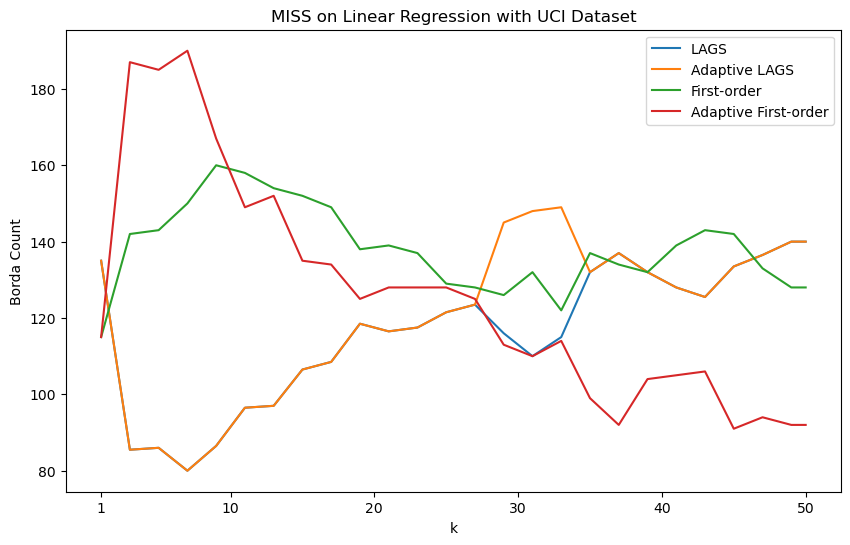

In [8]:
Borda_result = np.array(Parallel(n_jobs=50)(delayed(Borda_count)(scores_ks_method_combo[k_idx]) for k_idx in range(num_ks)))

plt.figure(figsize=(10, 6))

plt.title(f'MISS on Linear Regression with UCI Dataset')

plt.xlabel('k')
plt.ylabel('Borda Count')

# Plot each method's Borda Count against k
for method_idx, method_name in enumerate(methods):
    plt.plot(ks, Borda_result[:, method_idx], label=method_name)

plt.xticks(np.insert(np.arange(10, max(ks)+1, 10), 0, 1))
plt.legend(methods)
plt.show()

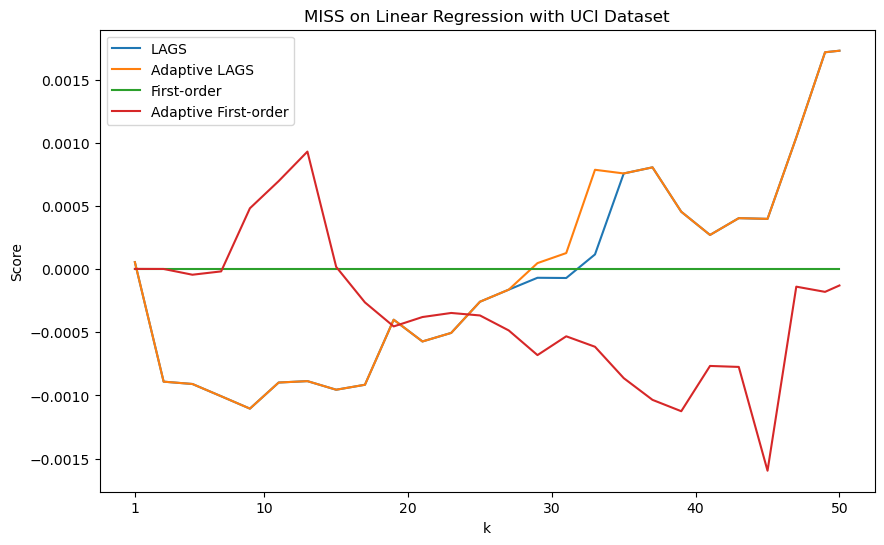

In [7]:
# Plot scores for each method
scores_ks_method_combo[np.isinf(scores_ks_method_combo)] = 0
scores_ks_method_combo[np.isnan(scores_ks_method_combo)] = 0

scores_ks_method = scores_ks_method_combo.mean(axis=2)

plt.figure(figsize=(10, 6))  # Create a single plot

plt.title(f'MISS on Linear Regression with UCI Dataset')

plt.xlabel('k')
plt.ylabel('Actual Effect')

for method_idx, method_name in enumerate(methods):
    plt.plot(ks, scores_ks_method[:, method_idx], label=method_name)

plt.xticks(np.insert(np.arange(10, max(ks)+1, 10), 0, 1))
plt.legend(methods)
plt.show()